In [25]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from collections import Counter

from covid19_abm.dir_manager import get_data_dir

In [26]:
age_map = {
    'less than 1 year': 0,
    'less than 1 year ': 0,
    '1 year': 1,
    '1 year ': 1,
    '2 years': 2,
    '2 years ': 2,
    '98': 98,
    '98 ': 98,
    'not reported/missing': None,
    'not reported/missing ': None,
}

econ_stat_map = {
    'Not working, inactive, not': 'Not working, inactive, not in universe',

}

#full_individual_df = pd.read_stata(
    #get_data_dir('raw', 'census', 'abm_individual_new_092220_final_merged_complete_FINAL.dta'))

    
full_individual_df = pd.read_stata(get_data_dir('raw', 'census', '5_perc_sample', 'census_sample_5perc_040521.dta'))
full_individual_df['age'] = full_individual_df['age'].map(lambda x: age_map.get(x, x))


full_individual_df['economic_status'] = full_individual_df['economic_status'].astype(str)
full_individual_df.loc[full_individual_df['teachers'] != 0, 'economic_status'] = 'Teachers'
full_individual_df['economic_status'] = full_individual_df['economic_status'].str.strip().map(lambda x: econ_stat_map.get(x, x))

In [27]:
full_individual_df['economic_status'].value_counts()

Current Students                          229861
Not working, inactive, not in universe    182559
Agriculture workers                       120555
Service workers                           111559
Homemakers/Housework                       66645
Office workers                             17241
Disabled and not working                    8902
Teachers                                    7129
Industry Workers                            6301
In the army                                 2144
Name: economic_status, dtype: int64

In [28]:
full_individual_df.head(1)

,household_id,persons,strata,gq,urban,hhtype,nfams,pernum,famunit,famsize,...,Ed_dist,Type,HotseatingIndicator,hotseating_session,phase,boardingschool,school_goers_detailed,geo1_zw2012,geo2_zw2012,economic_status
0,7012000,5,2515,households,urban,married/cohab couple with children,1 family,2,1,5,...,,,NaN,NaN,0.0,NaN,0,bulawayo,bulawayo urban,Homemakers/Housework


In [29]:
full_individual_df["school_goers"].value_counts()

0.0             516322
School Goers    236574
Name: school_goers, dtype: int64

In [30]:
(
    ((full_individual_df["teachers"] > 0) & (full_individual_df["school_goers"] > 0)).sum(),
    ((full_individual_df["teachers"] > 0) & (full_individual_df["school_goers"] > 0) & (full_individual_df["Schoolnumber"].notnull())).sum(),
    (full_individual_df["teachers"] > 0).sum()
)

(6713, 6713, 7129)

# Fill unknown age

In [31]:
# first identify if there are missing ages 
full_individual_df.isnull().sum()

household_id                  0
persons                       0
strata                        0
gq                            0
urban                         0
                          ...  
boardingschool           516322
school_goers_detailed         0
geo1_zw2012                   0
geo2_zw2012                   0
economic_status               0
Length: 61, dtype: int64

In [33]:
full_individual_df['age'].isnull().sum()

1639

In [39]:
full_individual_df['age'].value_counts()

0     24768
1     24532
12    23780
2     23741
4     21076
      ...  
94      181
93      125
95       70
96       55
97       53
Name: age, Length: 99, dtype: int64

In [34]:
individual_df = full_individual_df

age_cols = [
    'district_id',
    'urban', 'persons', 'sex', 'marst', 'citizen', 'race', 'disabled', 'economic_status']
X = pd.get_dummies(individual_df[age_cols], drop_first=True)

X_train = X[individual_df['age'].notnull()]

In [35]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=1029)
# rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=1029, n_jobs=50)

frac = 0.05
X_tr = X_train.sample(frac=frac, random_state=1029)
gb.fit(X_tr, individual_df.loc[X_tr.index, 'age'])

missing_age = X[individual_df['age'].isnull()]

<AxesSubplot:>

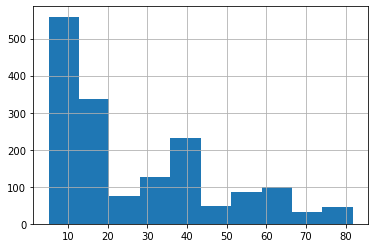

In [36]:
pd.Series(gb.predict(missing_age)).hist()

#code is reincluded for 5 perc

In [37]:
X_tr.shape

(37563, 26)

In [40]:
full_individual_df['age'].isnull().sum()

1639

In [41]:
#individual_df.loc[missing_age.index, 'age'] = gb.predict(missing_age).astype(int)
individual_df.loc[missing_age.index].head(1)

,household_id,persons,strata,gq,urban,hhtype,nfams,pernum,famunit,famsize,...,Ed_dist,Type,HotseatingIndicator,hotseating_session,phase,boardingschool,school_goers_detailed,geo1_zw2012,geo2_zw2012,economic_status
898,2274000,8,15841,households,urban,"extended family, relatives only",1 family,2,1,8,...,,,NaN,NaN,0.0,NaN,0,bulawayo,bulawayo urban,"Not working, inactive, not in universe"


In [46]:
full_individual_df.head(1)

,household_id,persons,strata,gq,urban,hhtype,nfams,pernum,famunit,famsize,...,Ed_dist,Type,HotseatingIndicator,hotseating_session,phase,boardingschool,school_goers_detailed,geo1_zw2012,geo2_zw2012,economic_status
0,7012000,5,2515,households,urban,married/cohab couple with children,1 family,2,1,5,...,,,NaN,NaN,0.0,NaN,0,bulawayo,bulawayo urban,Homemakers/Housework


In [44]:
# replace the missing ages with predicted values where missing
individual_df.age(None, individual_df.missing_age, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'missing_age'

In [40]:
individual_df.economic_status.astype(str).value_counts()

In School                                 43
Not working, inactive, not in universe    41
Agriculture Workers                       22
Homemakers/Housework                      16
Service Workers                           14
Office workers                             7
Disabled and not working                   3
Teachers                                   2
Indusrtry Workers                          1
Name: economic_status, dtype: int64

time: 4.35 ms


## Create `district_id`, `household_id` and `economic_activity_location_id`

In [41]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'district_id',
    'economic_status', 'economic_activity_location_id',
    'school_id',
    'hotseating_session',
    'phase',
    'boardingschool'
    # 'household', 'district'
]

time: 417 µs


In [42]:
individual_df['Schoolnumber'].value_counts()

16810.0    1
4201.0     1
2987.0     1
16771.0    1
14529.0    1
6029.0     1
11105.0    1
8408.0     1
2541.0     1
2954.0     1
12641.0    1
16214.0    1
8669.0     1
16889.0    1
17110.0    1
10701.0    1
6281.0     1
12432.0    1
1116.0     1
1192.0     1
1024.0     1
6623.0     1
1306.0     1
7066.0     1
2878.0     1
2223.0     1
16759.0    1
16738.0    1
6261.0     1
16603.0    1
14385.0    1
12600.0    1
17040.0    1
2550.0     1
10235.0    1
12447.0    1
14655.0    1
6931.0     1
8429.0     1
6393.0     1
2413.0     1
6145.0     1
16180.0    1
1226.0     1
12640.0    1
Name: Schoolnumber, dtype: int64

time: 5.24 ms


In [43]:
old_new_districts = pd.read_csv(
    get_data_dir('raw', 'district_relation.csv'), index_col=0)
old_new_districts.index = old_new_districts['ADMIN_NAME'].str.lower()

***FLAG***/Users/sophieayling/Documents/GitHub/covid19-agent-based-model
time: 15.6 ms


In [44]:
individual_df['serial_expanded'] = individual_df['serial_cycle']

time: 1.5 ms


In [45]:
individual_df['new_district_id'].value_counts().head()

2     24
1      8
7      5
57     4
55     4
Name: new_district_id, dtype: int64

time: 5.56 ms


In [46]:
individual_df['household_id'] = individual_df['serial_expanded'].map(lambda x: f'h_{x}')
individual_df['new_district_id'] = individual_df['new_district_id'].map(lambda x: f'd_{x}')

time: 2.98 ms


In [47]:
expanded_individual_df = individual_df.copy()
expanded_individual_df.head(1)

,serial,persons,strata,gq,urban,hhtype,nfams,pernum,famunit,famsize,...,SchoolLevel,Grant_Class,Ed_dist,Type,HotseatingIndicator,hotseating_session,phase,boardingschool,serial_expanded,household_id
0,4718000,5,6994,households,urban,married/cohab couple with children,1 family,3,1,5,...,Secondary,S2,Bulawayo,Government,1.0,Morning,3.0,Not Boarding School,471800018,h_471800018


time: 34.9 ms


In [48]:
individual_df['hotseating_session'].value_counts()

0.0        35
Morning     7
Evening     3
Name: hotseating_session, dtype: int64

time: 11.6 ms


In [49]:
expanded_individual_df['school_goers'] = 1 * (expanded_individual_df['school_goers'] != 0)

time: 2.12 ms


In [50]:
(expanded_individual_df.groupby('serial_expanded')['sex'].count().mean(), 
expanded_individual_df.shape[0] / expanded_individual_df['serial_expanded'].nunique())

(1.0, 1.0)

time: 12.9 ms


In [51]:
(expanded_individual_df['school_goers'] == 1).sum()

45

time: 2.79 ms


# Data consolidation

In [52]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'district_id',
    'economic_status', 'economic_activity_location_id',
    # 'school_id_district', 
    'school_goers',
    'manufacturing_workers',
    'school_id',
    'hotseating_session', 
    'phase',
    'boardingschool'
    # 'mining_district_id'
    # 'household', 'district'
]

time: 411 µs


In [53]:
consolidated_df = expanded_individual_df.copy()

p = consolidated_df['economic_status']

consolidated_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p == 'Disabled and not working', 'household_id']
consolidated_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p != 'Disabled and not working', 'new_district_id']

try:
    consolidated_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

consolidated_df['person_id'] = consolidated_df.index
consolidated_df['age'] = consolidated_df['age'].astype(int)
consolidated_df['economic_status'] = consolidated_df['economic_status'].str.strip()

consolidated_df.rename(columns={'district_id': 'old_district_id1'}, inplace=True) # added 30th Nov (Sophie, Anne, Sarah)

consolidated_df['school_id'] = consolidated_df['Schoolnumber'].fillna(-1).astype(int).map(lambda x: f's_{x}')  # if x != -1 else '')
consolidated_df['district_id'] = consolidated_df['new_district_id']

time: 39.6 ms


In [54]:
consolidated_df[relevant_cols].to_pickle(
    get_data_dir('preprocessed', 'census', 'zimbabwe_expanded_census_consolidated_100pct.pickle'))

***FLAG***/Users/sophieayling/Documents/GitHub/covid19-agent-based-model
time: 16 ms


In [55]:
consolidated_df[relevant_cols].head()

,person_id,age,sex,household_id,district_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers,school_id,hotseating_session,phase,boardingschool
0,0,14,male,h_471800018,d_1,In School,d_1,1,0.0,s_12641,Morning,3.0,Not Boarding School
1,1,4,male,h_667100009,d_1,"Not working, inactive, not in universe",d_1,0,0.0,s_-1,NaN,0.0,NaN
2,2,35,male,h_113600005,d_1,"Not working, inactive, not in universe",d_1,0,0.0,s_-1,NaN,0.0,NaN
3,3,0,female,h_217800002,d_1,"Not working, inactive, not in universe",d_1,0,0.0,s_-1,NaN,0.0,NaN
4,4,16,female,h_299800010,d_1,In School,d_1,1,0.0,s_12640,0,2.0,Not Boarding School


time: 19.3 ms


In [56]:
consolidated_df[relevant_cols][consolidated_df[relevant_cols]["phase"] == 1].head()

,person_id,age,sex,household_id,district_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers,school_id,hotseating_session,phase,boardingschool
24,24,17,male,h_14033200009,d_2,In School,d_2,1,0.0,s_1306,0,1.0,Not Boarding School
78,78,17,male,h_4753900017,d_25,In School,d_25,1,0.0,s_6029,0,1.0,Day and Boarding
79,79,13,male,h_5976300010,d_26,In School,d_26,1,0.0,s_8429,Morning,1.0,Not Boarding School
139,139,17,male,h_10971600011,d_56,In School,d_56,1,0.0,s_16771,Morning,1.0,Not Boarding School
144,144,17,female,h_11037000013,d_57,In School,d_57,1,0.0,s_16214,0,1.0,Not Boarding School


time: 23.3 ms


In [57]:
consolidated_df[consolidated_df['school_id'] != '']['school_id']

0      s_12641
1         s_-1
2         s_-1
3         s_-1
4      s_12640
        ...   
144    s_16214
145    s_16759
146    s_16180
147    s_16738
148    s_16889
Name: school_id, Length: 149, dtype: object

time: 10.5 ms


In [58]:
consolidated_df.loc[consolidated_df['school_id'] != '', 'school_id'].unique()

array(['s_12641', 's_-1', 's_12640', 's_1024', 's_1192', 's_1306',
       's_1116', 's_1226', 's_2413', 's_2541', 's_2550', 's_2987',
       's_2954', 's_2223', 's_2878', 's_4201', 's_6931', 's_6281',
       's_6145', 's_6393', 's_6261', 's_6623', 's_7066', 's_6029',
       's_8429', 's_8408', 's_8669', 's_10701', 's_10235', 's_11105',
       's_12432', 's_12447', 's_12600', 's_14529', 's_14655', 's_14385',
       's_17110', 's_16771', 's_17040', 's_16810', 's_16603', 's_16214',
       's_16759', 's_16180', 's_16738', 's_16889'], dtype=object)

time: 3.51 ms


In [59]:
consolidated_df[relevant_cols].head()

,person_id,age,sex,household_id,district_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers,school_id,hotseating_session,phase,boardingschool
0,0,14,male,h_471800018,d_1,In School,d_1,1,0.0,s_12641,Morning,3.0,Not Boarding School
1,1,4,male,h_667100009,d_1,"Not working, inactive, not in universe",d_1,0,0.0,s_-1,NaN,0.0,NaN
2,2,35,male,h_113600005,d_1,"Not working, inactive, not in universe",d_1,0,0.0,s_-1,NaN,0.0,NaN
3,3,0,female,h_217800002,d_1,"Not working, inactive, not in universe",d_1,0,0.0,s_-1,NaN,0.0,NaN
4,4,16,female,h_299800010,d_1,In School,d_1,1,0.0,s_12640,0,2.0,Not Boarding School


time: 19.2 ms


In [60]:
individual_df['mining_districts'].describe()

count    149.000000
mean       0.234899
std        0.425366
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: mining_districts, dtype: float64

time: 13.9 ms


In [61]:
print(individual_df.columns[individual_df.columns.str.contains('manufacturing')])
print(individual_df.columns[individual_df.columns.str.contains('mining')])

Index(['manufacturing_workers'], dtype='object')
Index(['mining_workers', 'mining_districts'], dtype='object')
time: 1.84 ms


# Contingent on available data

In [62]:
# consolidated_df['serial_expanded'] = consolidated_df['serial'].map(lambda x: f'{x}_01')
# consolidated_df['household_id'] = consolidated_df['serial_expanded'].map(lambda x: f'h_{x}')
consolidated_df.loc[consolidated_df['mining_district_id'] != '', 'mining_district_id'] = consolidated_df.loc[consolidated_df['mining_district_id'] != '', 'mining_district_id'].map(lambda x: f'mining_{x}')
consolidated_df.loc[consolidated_df['school_id_district'] != '', 'school_id_district'] = consolidated_df.loc[consolidated_df['school_id_district'] != '', 'school_id_district'].map(lambda x: f'school_{x}')

KeyError: 'mining_district_id'

time: 36.8 ms


In [ ]:
consolidated_df.head()

In [ ]:
p = consolidated_df['economic_status']

consolidated_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p == 'Disabled and not working', 'household_id']
consolidated_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p != 'Disabled and not working', 'new_district_id']

In [ ]:
try:
    consolidated_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

consolidated_df['person_id'] = consolidated_df.index
consolidated_df['age'] = consolidated_df['age'].astype(int)
consolidated_df['economic_status'] = consolidated_df['economic_status'].str.strip()
consolidated_df.rename(columns={'new_district_id': 'district_id'}, inplace=True)

In [ ]:
consolidated_df[relevant_cols][
    consolidated_df.serial_expanded.str.endswith('_01')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_5pct.pickle')

In [ ]:
consolidated_df[relevant_cols][
    consolidated_df.serial_expanded.str.endswith('_01') | consolidated_df.serial_expanded.str.endswith('_02')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
consolidated_df.shape

In [ ]:
import pandas as pd

In [ ]:
consolidated_df = pd.read_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
consolidated_df[consolidated_df['school_id_district'] != '']['person_id']

# Expand to 10%

In [ ]:
mining_df

# Scratch

In [ ]:
mining_df[~mining_df['household_id'].str.startswith('h_')]['person_id'].values

In [ ]:
mining_df[mining_df.manufacturing_workers.notnull()].person_id

In [ ]:
mining_df[mining_df['manufacturing_workers'].notnull()]['person_id'].values

In [ ]:
mining_df[mining_df['school_id_district'] != '']['person_id'].values

In [ ]:
mining_df['school_id_district'].shape